# Downloading Necessary Files

In [9]:
%pip install -q mediapipe
!wget -q https://storage.googleapis.com/mediapipe-models/gesture_recognizer/gesture_recognizer/float16/1/gesture_recognizer.task

Note: you may need to restart the kernel to use updated packages.


# Imports

In [1]:
import os
import cv2
import math
import time
import pickle
import numpy as np

import mediapipe as mp

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

plt.style.use("seaborn-v0_8-dark")
plt.rcParams["font.family"] = "monospace"

# Definiton of User-Variables & Functions

In [5]:
DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480
CAP = cv2.VideoCapture(0)
CLASS = ["Open Palm", "Peace Sign", "Rock On", "OK Sign","NOK Sign"]
DATA_DIR = r"C:\Users\serce\Desktop\MLProje\data\training"
CLASS_IDX = 0
COUNT = 0
TOTAL = 100

def resize(image, DESIRED_HEIGHT, DESIRED_WIDTH):
    H, W = image.shape[:2]
    if H < W:       # Portrait
        image = cv2.resize(image, (DESIRED_WIDTH, math.floor(H / (W / DESIRED_WIDTH))))
    else:
        image = cv2.resize(image, (math.floor(W / (H / DESIRED_HEIGHT)), DESIRED_HEIGHT))
    return image

# Definition of Holistic Model from Mediapipe

In [6]:
HANDS = mp.solutions.hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.5
)
DRAW = mp.solutions.drawing_utils

# Dataset Collection

In [25]:
while CAP.isOpened():
    ret, frame = CAP.read()
    if not ret:
        print("Ignoring empty camera frame.")
        continue
    
    frame = resize(frame, DESIRED_HEIGHT, DESIRED_WIDTH)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    cv2.imshow('MediaPipe Hands', frame)
    
    # Save the frame if 's' key is pressed (100 images per class)
    if cv2.waitKey(5) & 0xFF == ord('s') and COUNT < TOTAL:
        time.sleep(1)
        img_name = os.path.join(DATA_DIR, CLASS[CLASS_IDX], f"{COUNT}.jpg")
        cv2.imwrite(img_name, frame)
        print(f"Saved frame as '{img_name}'")
        COUNT += 1
        if COUNT >= TOTAL:
            COUNT = 0
            CLASS_IDX += 1
            if CLASS_IDX >= len(CLASS):
                break

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

CAP.release()
cv2.destroyAllWindows()

Saved frame as 'C:\Users\serce\Desktop\MLProje\data\training\Open Palm\0.jpg'
Saved frame as 'C:\Users\serce\Desktop\MLProje\data\training\Open Palm\1.jpg'
Saved frame as 'C:\Users\serce\Desktop\MLProje\data\training\Open Palm\2.jpg'
Saved frame as 'C:\Users\serce\Desktop\MLProje\data\training\Open Palm\3.jpg'
Saved frame as 'C:\Users\serce\Desktop\MLProje\data\training\Open Palm\4.jpg'
Saved frame as 'C:\Users\serce\Desktop\MLProje\data\training\Open Palm\5.jpg'
Saved frame as 'C:\Users\serce\Desktop\MLProje\data\training\Open Palm\6.jpg'
Saved frame as 'C:\Users\serce\Desktop\MLProje\data\training\Open Palm\7.jpg'
Saved frame as 'C:\Users\serce\Desktop\MLProje\data\training\Open Palm\8.jpg'
Saved frame as 'C:\Users\serce\Desktop\MLProje\data\training\Open Palm\9.jpg'
Saved frame as 'C:\Users\serce\Desktop\MLProje\data\training\Open Palm\10.jpg'
Saved frame as 'C:\Users\serce\Desktop\MLProje\data\training\Open Palm\11.jpg'
Saved frame as 'C:\Users\serce\Desktop\MLProje\data\training\O

# Visualization of Data

In [ ]:
# Process saved images and extract hand landmarks
CLASS = ["Open Palm", "Peace Sign", "Rock On", "OK Sign","NOK Sign"]

images = []
labels = []
for i, class_name in enumerate(CLASS):
    img_dir = os.path.join(DATA_DIR, class_name)
    for img_name in os.listdir(img_dir):
        img = cv2.imread(os.path.join(img_dir, img_name))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img_rgb)
        labels.append(i)

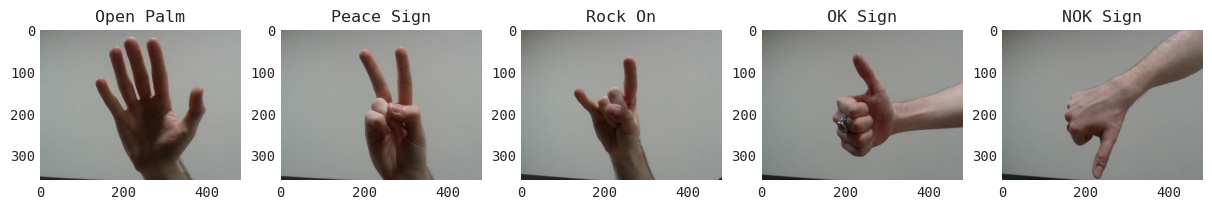

In [ ]:
# Plot 1 image from all the classes
plt.figure(figsize=(15, 10))
for label, img in zip(labels, images):
    plt.subplot(1, 5, label + 1)
    plt.imshow(img)
    plt.title(CLASS[label])

## Saving Data in `.csv` Format

In [24]:
X = []
y = []

for i, class_name in enumerate(CLASS):
    with os.scandir(os.path.join(DATA_DIR, class_name)) as entries:
        for entry in entries:
            image = cv2.imread(entry.path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = HANDS.process(image_rgb)
            if results.multi_hand_landmarks:
                hand_landmarks = results.multi_hand_landmarks[0]
                landmarks = np.array([[landmark.x, landmark.y, landmark.z] for landmark in hand_landmarks.landmark]).flatten()
                X.append(landmarks)
                y.append(i)
                
# Save new training data as .csv
X = np.array(X)
y = np.array(y)

df = pd.DataFrame(X)
df['label'] = y
df.to_csv('hand_landmarks.csv', index=False)

d:\anaconda3\envs\slave\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


# Loading & Processing `.csv` Data

In [25]:
# Load the .csv data
data = pd.read_csv('hand_landmarks.csv')

# Split the data into features and labels
X = data.drop('label', axis=1).values 
y = data['label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (400, 63)
X_test shape: (100, 63)


# Defining & Training a Model

In [27]:
# Define training parameters for Random Forest Classifier
MODEL = RandomForestClassifier(n_estimators=10, random_state=42)

# Train the model
MODEL.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=42)

# Evaluating

In [28]:
# Evaluate the model
y_pred = MODEL.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        28
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        10
           3       1.00      0.92      0.96        24
           4       0.96      1.00      0.98        24

    accuracy                           0.98       100
   macro avg       0.99      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



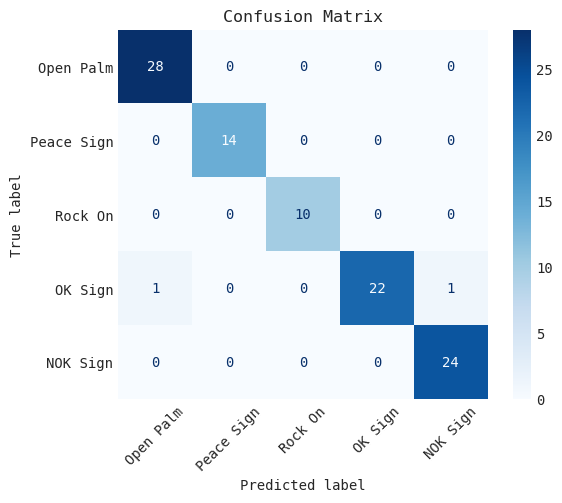

In [46]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(MODEL, X_test, y_test, display_labels=CLASS, cmap='Blues')        # `Blues_r` olarak da kullanılabilir
plt.xticks(rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [14]:
# Save the model
with open('hand_gesture_model.pkl', 'wb') as f:
    pickle.dump(MODEL, f)